# Class representations in image tokens

In [69]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
from scipy.stats import wilcoxon
import torch

from src.accuracy import compute_accuracy
from src.identifiability import (
    get_class_embed, get_ident_mean_evolution, get_ident_change_rate,
    get_ident_segmented, compute_context_diff
)
from src.vis import Vis

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

__TO-DO__: Define your path to the project folder and ImageNet-S dataset here:

In [3]:
PROJ_PATH = []
DATASET_PATH = [] 
CIFAR_PATH = []

In [4]:
# Define paths
PROJ_PATH = Path(PROJ_PATH)
DATASET_PATH = Path(DATASET_PATH)
RES_PATH = PROJ_PATH / 'results'

# Create figures path
(RES_PATH / 'figures').mkdir(parents=True, exist_ok=True)

__Mapping of model names__

In [6]:
MODEL_MAP = {
    'vit_b_32': 'ViT-B/32',
    'vit_b_16': 'ViT-B/16',
    'vit_large_16': 'ViT-L/16',
    'vit_miil_16': 'ViT-B/16-MIIL',
    'vit_cifar_16': 'ViT-B/16-CIFAR',
    'deit_ensemble_16': 'ViT-B/16-Refinement',
    'vit_gap_16': 'ViT-B/16-GAP',
}

## Class representations in image tokens

We measure the __class identifiability rate__, which we quantified as the percentage of tokens that contain a class identifiability score of 1. 

We also measure the percentage of images that contain at least one image token with an identifiability score of 1 in the last block.

In [7]:
def compute_identifiability(model_name, layer=11, dataset_path=DATASET_PATH):
    """
    Compute and print class identifiability measures.
    """
    # Get class identifiability
    dec = get_class_embed(RES_PATH, dataset_path, model_name, f'hs_{layer}', 'pos')[:, 1:]
    
    # Compute class identifiability rate
    avg_percentage = (torch.sum(dec == 0, dim=1) / dec.shape[1]).float().mean() * 100
    print(f'- Average percentage of class identifiable image tokens per image: {avg_percentage}')
    
    # Compute percentage of images with at least one identifiable token
    image_percentage = torch.sum((torch.sum((dec == 0), dim=1) > 0)) / dec.shape[0] * 100
    print(
        f'- Percentage of images with at least one class identifiable token: {image_percentage}'
    )
    
    # Plot histogram
    print('- Histogram of the number of decodable image tokens:')
    fig, ax = plt.subplots(figsize=(5,3))
    ax.hist(torch.sum((dec == 0), dim=1).detach().numpy(), bins=50)
    plt.show()
    
    return

#### ViT-B/32

- Average percentage of class identifiable image tokens per image: 60.726173400878906
- Percentage of images with at least one class identifiable token: 95.5824203491211
- Histogram of the number of decodable image tokens:


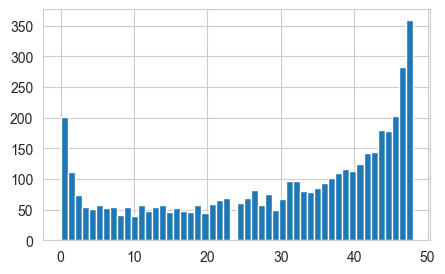

Accuracy: 81.71


In [8]:
model_name = 'vit_b_32'
compute_identifiability(model_name)
print(f'Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

#### ViT-B/16

- Average percentage of class identifiable image tokens per image: 67.04048156738281
- Percentage of images with at least one class identifiable token: 97.45054626464844
- Histogram of the number of decodable image tokens:


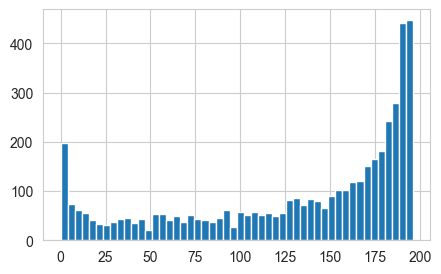

Accuracy: 85.69


In [9]:
model_name = 'vit_b_16'
compute_identifiability(model_name)
print(f'Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

#### ViT-L/16

- Average percentage of class identifiable image tokens per image: 63.59151077270508
- Percentage of images with at least one class identifiable token: 85.29669952392578
- Histogram of the number of decodable image tokens:


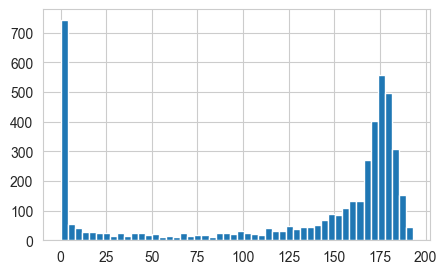

Accuracy: 86.00


In [16]:
model_name = 'vit_large_16'
compute_identifiability(model_name, layer=23)
print(f'Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

#### ViT-B/16 - MILL

- Average percentage of class identifiable image tokens per image: 78.49742126464844
- Percentage of images with at least one class identifiable token: 95.47252655029297
- Histogram of the number of decodable image tokens:


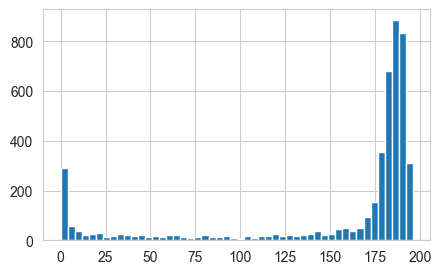

Accuracy: 86.26


In [11]:
model_name = 'vit_miil_16'
compute_identifiability(model_name)
print(f'Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

#### ViT-B/16 - CIFAR

- Average percentage of class identifiable image tokens per image: 90.35204315185547
- Percentage of images with at least one class identifiable token: 98.79999542236328
- Histogram of the number of decodable image tokens:


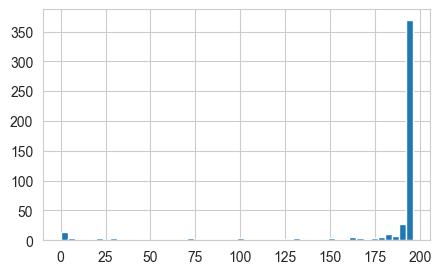

Accuracy: 92.00


In [12]:
model_name = 'vit_cifar_16'
compute_identifiability(model_name)
print(f'Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

#### ViT/B-16 - Refinement

- Average percentage of class identifiable image tokens per image: 79.66337585449219
- Percentage of images with at least one class identifiable token: 96.26373291015625
- Histogram of the number of decodable image tokens:


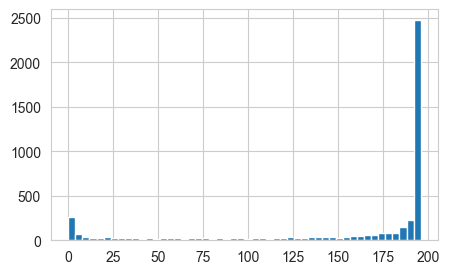

Accuracy: 84.97


In [13]:
model_name = 'deit_ensemble_16'
compute_identifiability(model_name)
print(f'Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

#### ViT-B/16 - GAP

- Average percentage of class identifiable image tokens per image: 52.10381317138672
- Percentage of images with at least one class identifiable token: 98.52747344970703
- Histogram of the number of decodable image tokens:


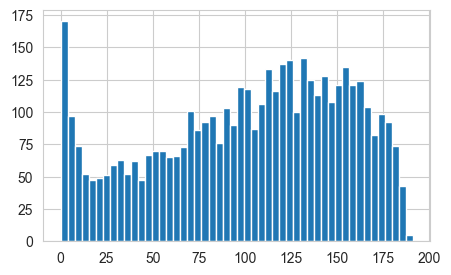

Accuracy: 84.13


In [14]:
model_name = 'vit_gap_16'
compute_identifiability(model_name)
print(f'Accuracy: {compute_accuracy(PROJ_PATH, DATASET_PATH, model_name):.2f}')

#### Comparison with random models

- Average percentage of class identifiable image tokens per image: 0.06638258695602417
- Percentage of images with at least one class identifiable token: 1.2747251987457275
- Histogram of the number of decodable image tokens:


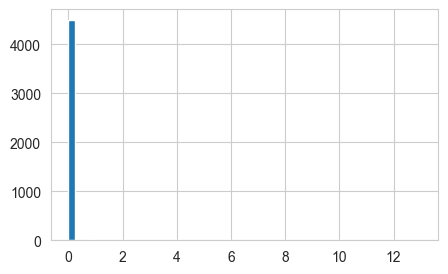

In [17]:
compute_identifiability('vit_b_32_random')

- Average percentage of class identifiable image tokens per image: 0.05617851763963699
- Percentage of images with at least one class identifiable token: 2.1758241653442383
- Histogram of the number of decodable image tokens:


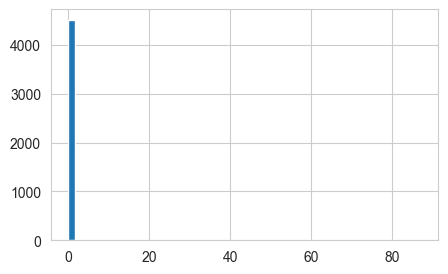

In [18]:
compute_identifiability('vit_b_16_random')

## Evolution of class representations across the hierarchy

### Class identifiability evolution

We projected the hidden states of every block into the class embedding space, and examined the evolution of their class identifiability scores. 

In [70]:
def label_token(row):
    """
    Assign to token its correct label.
    """
    if row['token'] == 0:
        return '[CLS]'
    else:
        return 'image'


def plot_identifiability_evolution(model_map=MODEL_MAP, dataset_path=DATASET_PATH, save=False):
    """
    Plot identifiability evolution over blocks.
    """
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(nrows=7, figsize=(13, 30))
    for model_name, ax in zip(model_map.keys(), axes.flat):
        if 'large' in model_name:
            n_layers = 24
        else:
            n_layers = 12
        
        dfs = []
        pvals = []
        for b in range(n_layers):
            # Get class identifiability of block
            dec = get_class_embed(
                RES_PATH, dataset_path, model_name, f'hs_{b}', 'pos', normalize=True
            )
            
            # Compare to random model
            if 'miil' in model_name:
                random_model = f'vit_b_16_random'
            else:
                random_model = f'{model_name}_random'
            rand_dec = get_class_embed(
                RES_PATH, dataset_path, random_model, f'hs_{b}', 'pos', normalize=True
            )
            wx = wilcoxon(dec.flatten(), rand_dec.flatten(), alternative='greater')
            pvals.append(np.round(wx.pvalue, 3))
            
            # Add to df
            df = (
                pd.DataFrame(pd.DataFrame(dec).stack())
                .reset_index(names=['image', 'token'])
                .rename(columns={0:'class identifiability'})
            )
            if 'gap' not in model_name:
                df['token label'] = df.apply(lambda row: label_token(row), axis=1)
            df['block'] = b + 1
            dfs.append(df)
        dfs = pd.concat(dfs)
        
        # Plot
        if 'gap' not in model_name:
            sns.boxplot(
                dfs, x='block', y='class identifiability', hue='token label', 
                fliersize=0, palette=sns.color_palette("Set2"), ax=ax
            )
            sns.move_legend(ax, 'lower right')
        else:
            sns.boxplot(
                dfs, x='block', y='class identifiability', fliersize=0, 
                palette=sns.color_palette(['#fc8d62']), ax=ax
            )
        ax.hlines(xmin=-1, xmax=n_layers, y=0.5, colors='dimgray', linestyles='--', lw=2)
    
        sig = np.where(np.array(pvals) < 0.05)[0]
        ax.scatter(sig, [1.1] * len(sig), marker='*', c='grey', s=45)
    
        ax.set_xlim(-0.5, int(n_layers))
        ax.set_title(f'{model_map[model_name]}')
        
    plt.tight_layout()
    f = RES_PATH / 'figures' / f'class_identifiability_evolution.png'
    plt.savefig(f, dpi=300)
    plt.show()
    
    return

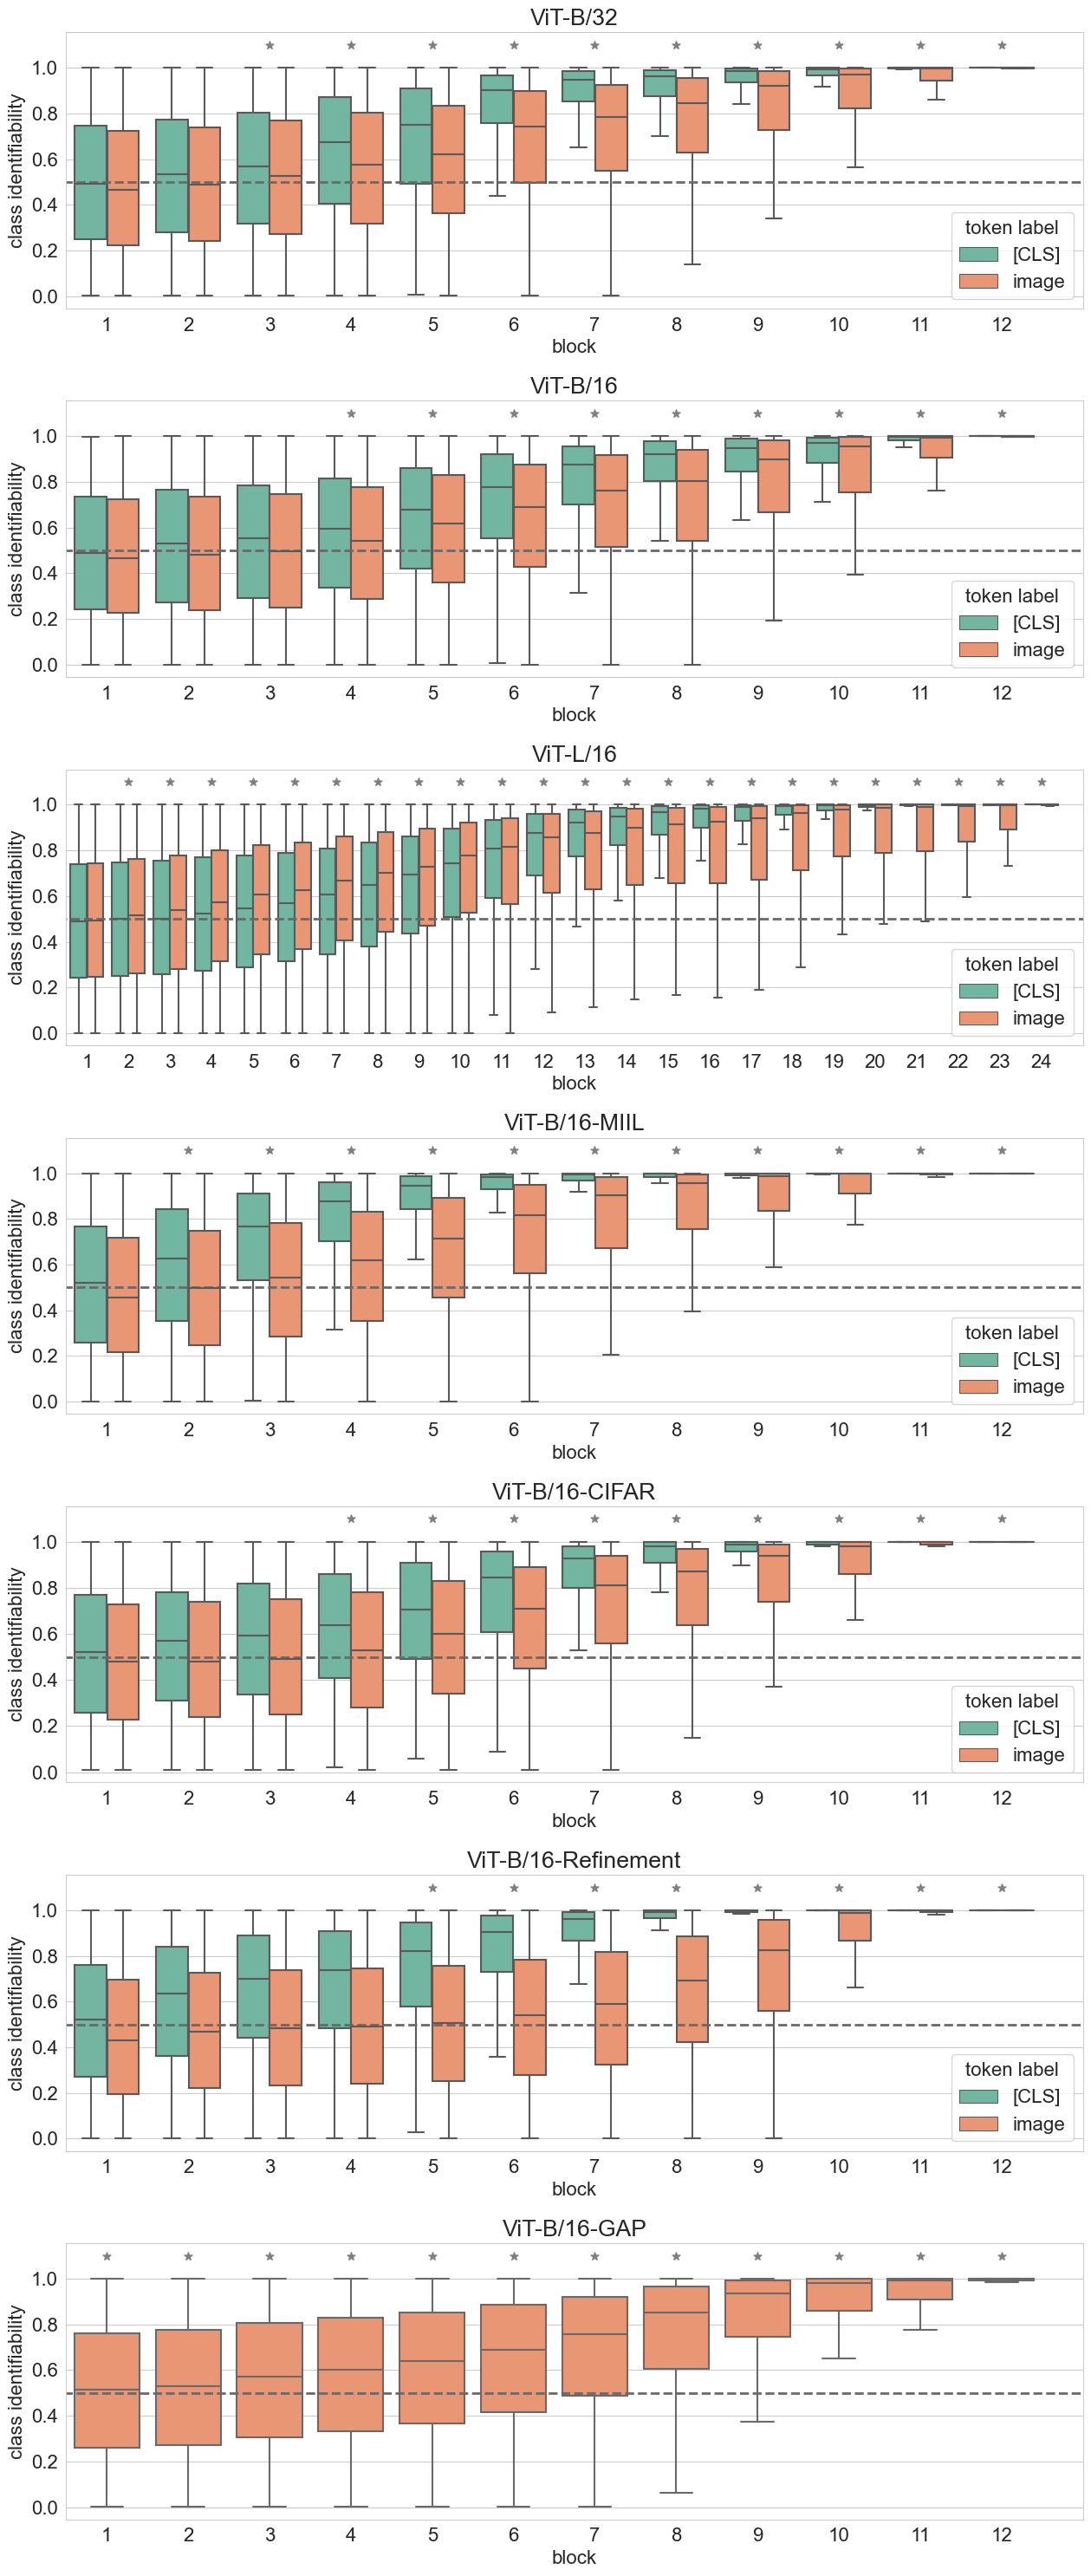

In [71]:
plot_identifiability_evolution()

#### Comparison all

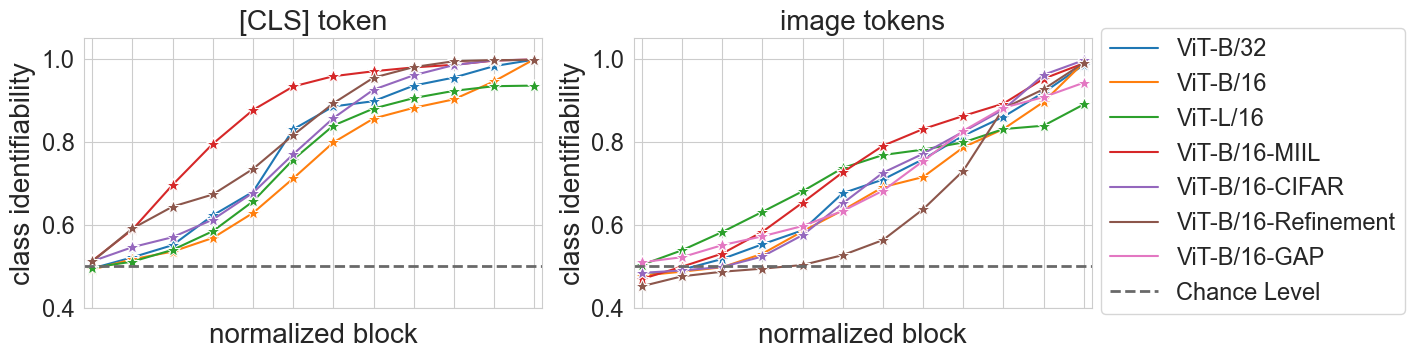

In [37]:
# Get evolution
df = []
for model in MODEL_MAP.keys():
    if 'cifar' in model:
        ident = get_ident_mean_evolution(model, CIFAR_PATH, RES_PATH)
    else:
        ident = get_ident_mean_evolution(model, DATASET_PATH, RES_PATH)
    df.append(ident)
df = pd.concat(df)
df['class identifiability'] = df['class identifiability'].astype('float')

# Plot
plt.rcParams.update({'font.size': 17})
fig, axes = plt.subplots(ncols=2, figsize=(13, 3.5))

cls_df = df.loc[df['token type'] == '[CLS]']
sns.lineplot(
    cls_df, x='block', y='class identifiability', hue='model', 
    ax=axes[0], marker='*', markersize=10
)
axes[0].set_title('[CLS] token')

img_df = df.loc[df['token type'] == 'image']
sns.lineplot(
    img_df, x='block', y='class identifiability', hue='model', 
    ax=axes[1], marker='*', markersize=10
)
axes[1].set_title('image tokens', fontsize=20)

for ax in axes.flat:
    ax.set_ylim(0.4, 1.05)
    ax.set_ylabel('class identifiability', fontsize=20)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(np.arange(1, 13))
    ax.set_xticklabels([])
    ax.set_xlim((0.8, 12.2))
    ax.set_xlabel('normalized block', fontsize=20)
    ax.hlines(
        xmin=0.8, xmax=12.2, y=0.5, colors='dimgray', linestyles='--', lw=2, 
        label='Chance Level'
    )

lines, labels = axes[1].get_legend_handles_labels()
lgd = fig.legend(
    lines, labels, loc='center right', #nrow=7,
    bbox_to_anchor=(1.15, 0.5),
)

for ax in axes.flat:
    ax.get_legend().remove()

f = RES_PATH / 'figures' / f'mean_evolution.png'
plt.savefig(f, dpi=300, bbox_inches='tight')
plt.show()

### Class similarity change rate

We computed the class similarity change rate of the output image tokens in each block.
Concretely, we computed the percentage of image tokens that increment the logits of the correct class per block. 

In [72]:
def plot_logits_increment(model_map=MODEL_MAP, dataset_path=DATASET_PATH):
    """
    Plot percentage of image tokens that increment the logits of the correct class.
    """
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 13))
    for model_name, ax in zip(model_map.keys(), axes.flat):
        
        if 'large' in model_name:
            n_layers = 24
            width = 8
        else:
            n_layers = 12
            width = 5
        
        # Get change rate 
        pers = get_ident_change_rate(model_name, dataset_path, RES_PATH, n_layers)

        # Plot
        sns.lineplot(pers, x='block', y='change rate', marker='o', markersize=9, ax=ax)
        ax.set_xlim(1.8, int(n_layers) + 0.2)
        ax.set_ylim(0.5, 1)
        ax.set_xticks(np.arange(2, int(n_layers) + 1))
        ax.xaxis.set_tick_params(labelsize=10)
        ax.set_yticks(np.arange(0.6, 1, 0.1))
        ax.yaxis.set_tick_params(labelsize=12)
        ax.set_title(model_map[model_name])
    
    fig.delaxes(axes[3,1])
        
    plt.tight_layout()
    f = RES_PATH / 'figures' / f'prob_increment.png'
    plt.savefig(f, dpi=300)
    plt.show()

    return

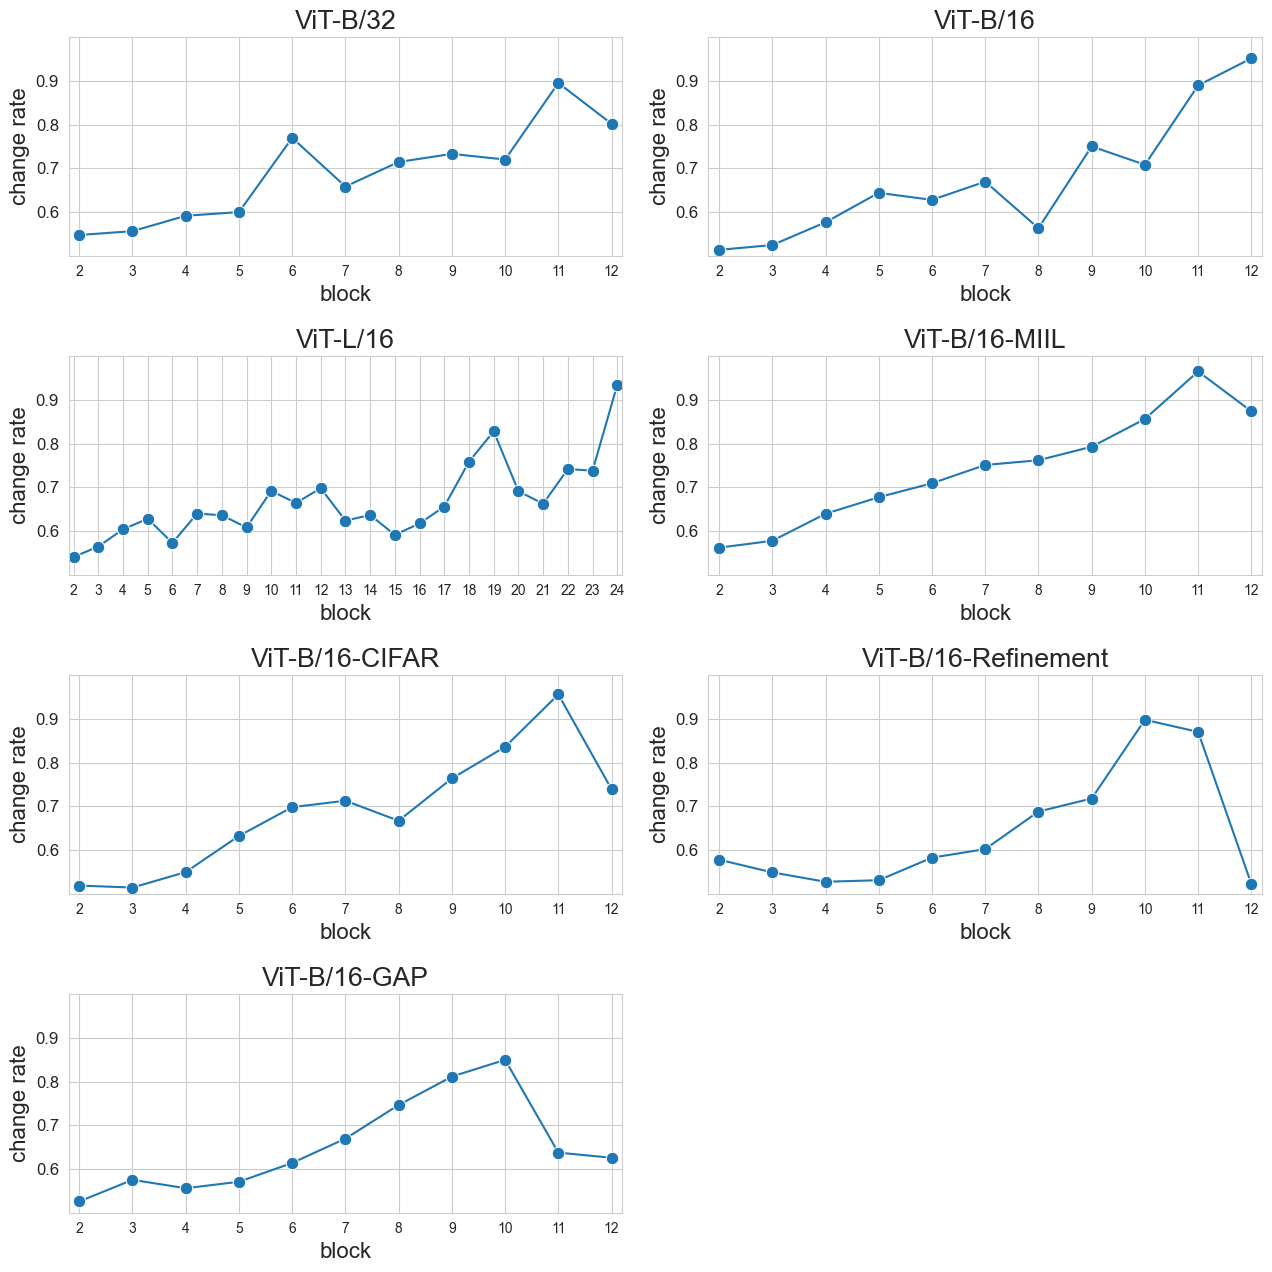

In [73]:
plot_logits_increment()

## The impact of attention mechanisms in the class representations of image tokens

In [52]:
def print_attn_perturb(model_name, perturb_type):
    """
    Print class identifiability of attention perturbation studies.
    """
    # Get perturbed identifiability
    f = RES_PATH / 'perturbation' / model_name / f'attn-{perturb_type}_dec.pt'
    attn_dec = torch.load(f, map_location='cpu')
    attn_dec = 1 - (attn_dec / 1000)
    attn_dec_acc = torch.sum(attn_dec == 1) / attn_dec.flatten().shape[0] * 100
    print(f'Class identifiability in {perturb_type}: {attn_dec_acc}')

    # Get unperturbed identifiability
    dec = get_class_embed(
        RES_PATH, DATASET_PATH, model_name, 'hs_11', decoding_type='pos', normalize=True
    )[:, 1:]
    dec_acc = torch.sum(dec == 1) / dec.flatten().shape[0] * 100
    print(f'Class identifiability in unperturbed model: {dec_acc}')
    
    return

### Pertubation studies with only self-attention weights

For the hidden representation of every token $i$ we set to 0 all attention weights from each image token $\mathbf{x}_i$ to every other image token $\{ \mathbf{x}_{j} : j \neq i\}$.

#### ViT-B/32

In [53]:
print_attn_perturb('vit_b_32', 'self_only')

Class identifiability in self_only: 0.1257142871618271
Class identifiability in unperturbed model: 60.726173400878906


### Perturbation studies with no attention from image tokens to [CLS]

We remove the attention weights between the image tokens and the [CLS] token.

#### ViT-B/32

In [54]:
print_attn_perturb('vit_b_32', 'no_cls')

Class identifiability in no_cls: 60.71340560913086
Class identifiability in unperturbed model: 60.726173400878906


## The impact of context on the class representations of image tokens

### Difference in identifiability evolution between class- and context-labeled tokens.

We compared the identifiability rate of class-labeled and context-labeled image tokens.

In [55]:
def plot_context_diff(model_name, dataset_path=DATASET_PATH):
    """
    Plot identifiability evolution separately for class- and context-labeled tokens.
    """
    dfs = get_ident_segmented(model_name, PROJ_PATH, dataset_path)

    if 'large' in model_name:
        nrows = 4
        n_layers = 24
        height = 10
    else:
        nrows = 2
        n_layers = 12
        height = 5

    plt.rcParams.update({'font.size': 12})
    fig, axes = plt.subplots(nrows=nrows, ncols=6, figsize=(13, height))
    for ax, b in zip(axes.flat, np.arange(n_layers)):
        df = dfs.loc[dfs['block'] == b]
        _, pval = compute_context_diff(df)
        sns.boxplot(
            df, y='class identifiability', x='token location',
            fliersize=0, ax=ax
        )
        if pval < 0.05:
            ax.set_title(f'block {b+1} *')
        else:
            ax.set_title(f'block {b+1}')
        ax.set_xlabel('')
    for ax in axes.flat[1:]:
        ax.set_ylabel('')
    fig.suptitle(MODEL_MAP[model_name])
    
    plt.tight_layout()
    f = RES_PATH / 'figures' / f'context_{model_name}.png'
    plt.savefig(f, dpi=300)
    plt.show()
    
    return

#### ViT-B/32

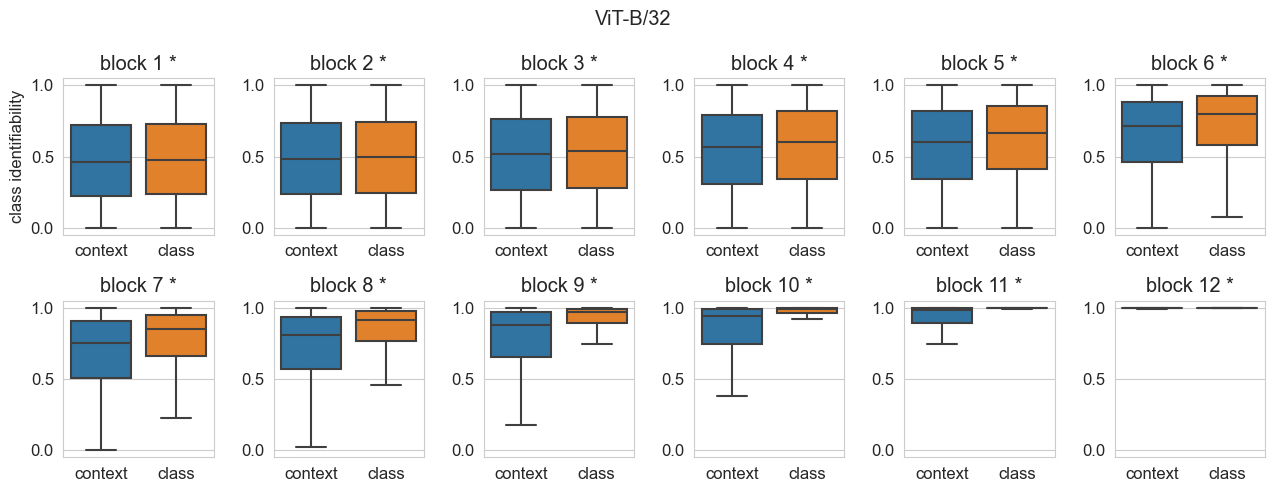

In [56]:
plot_context_diff('vit_b_32')

#### ViT-B/16

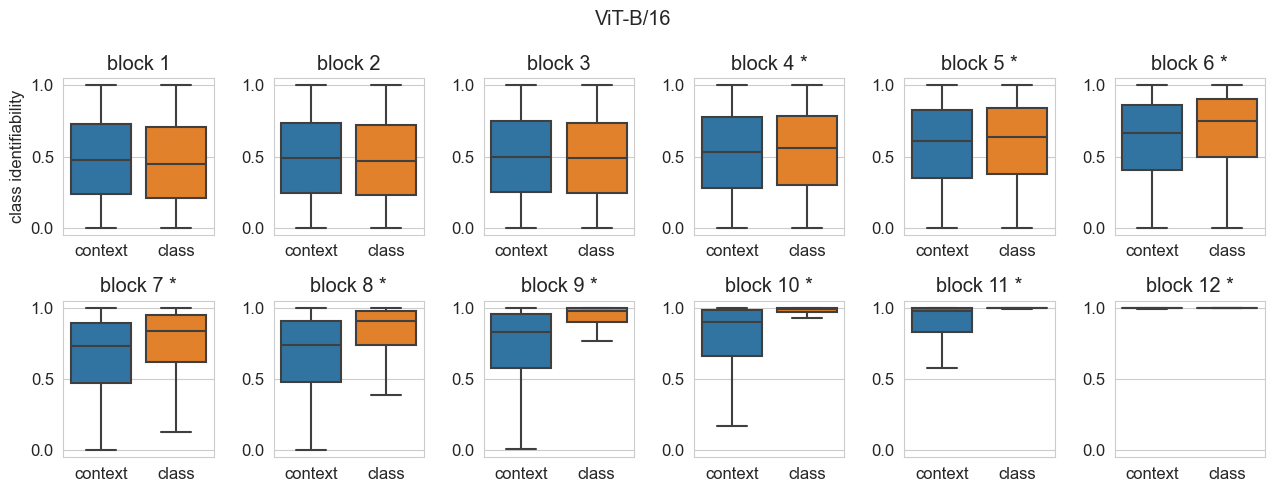

In [57]:
plot_context_diff('vit_b_16')

#### ViT-L/16

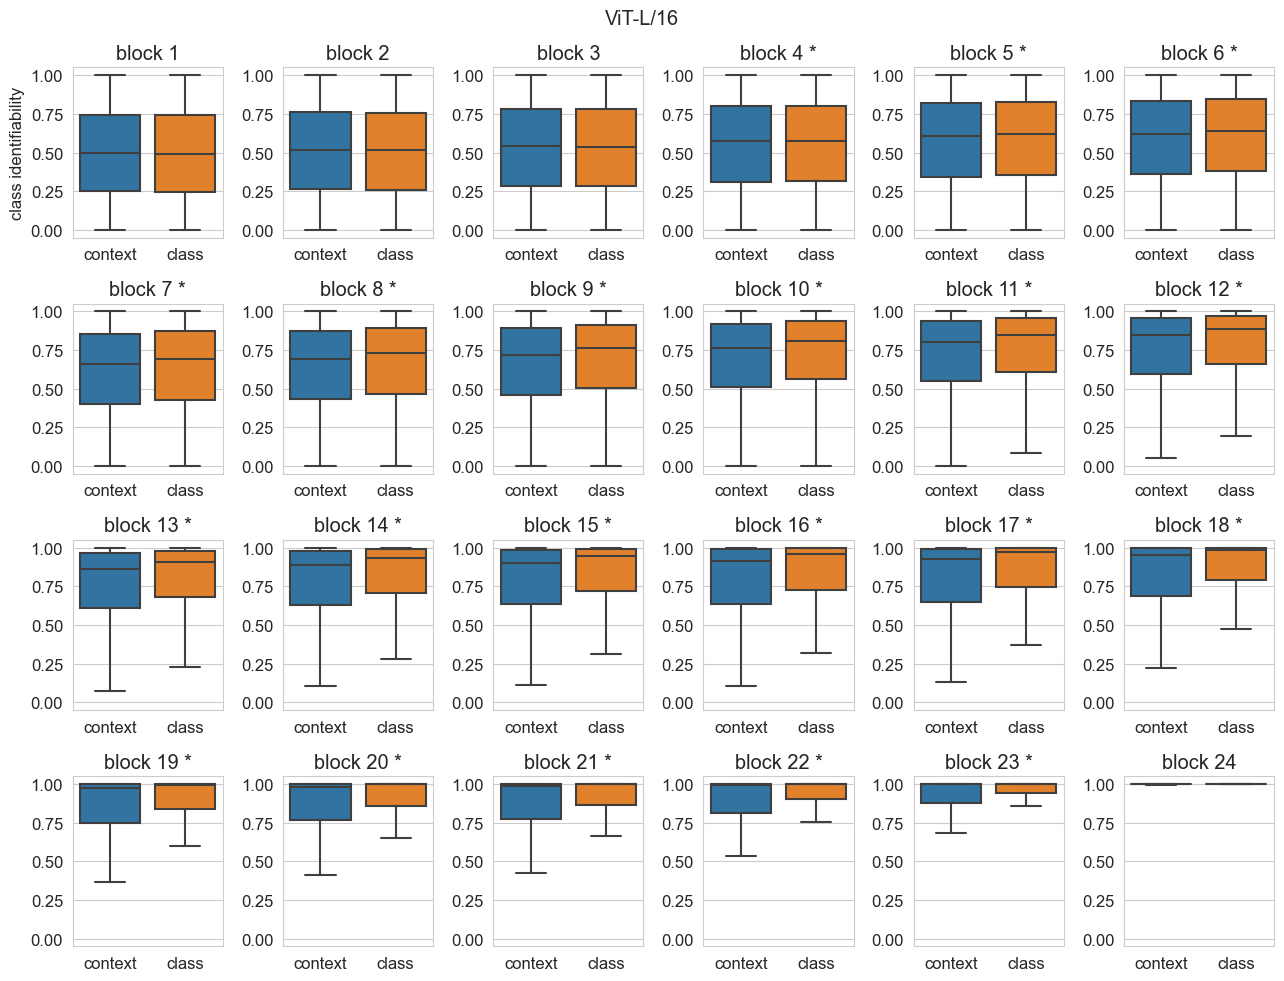

In [58]:
 plot_context_diff('vit_large_16')

#### ViT-B/16 - MIIL 

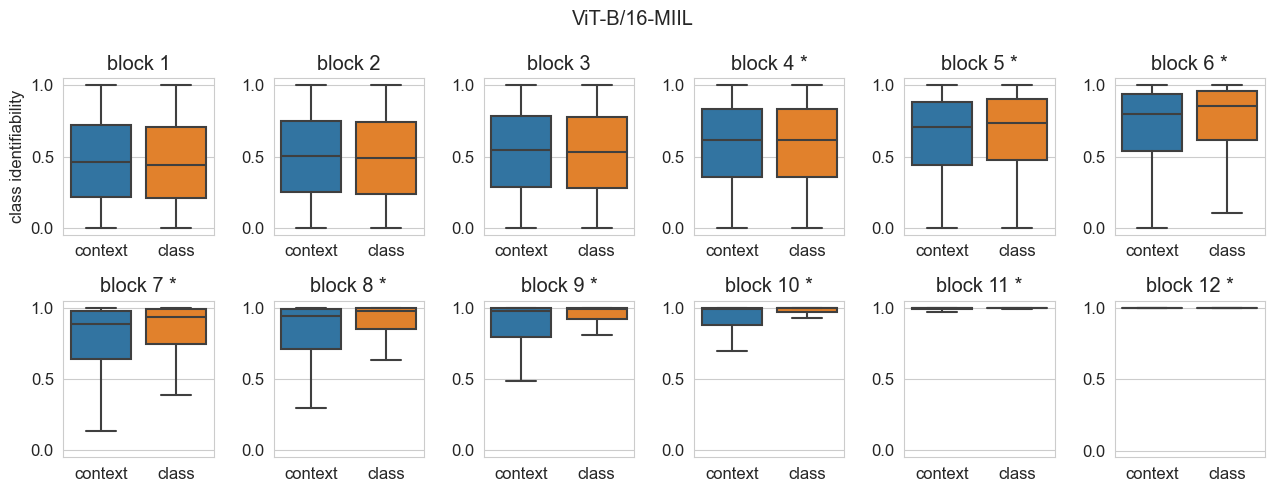

In [59]:
plot_context_diff('vit_miil_16')

#### ViT-B/16 - Refinement

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


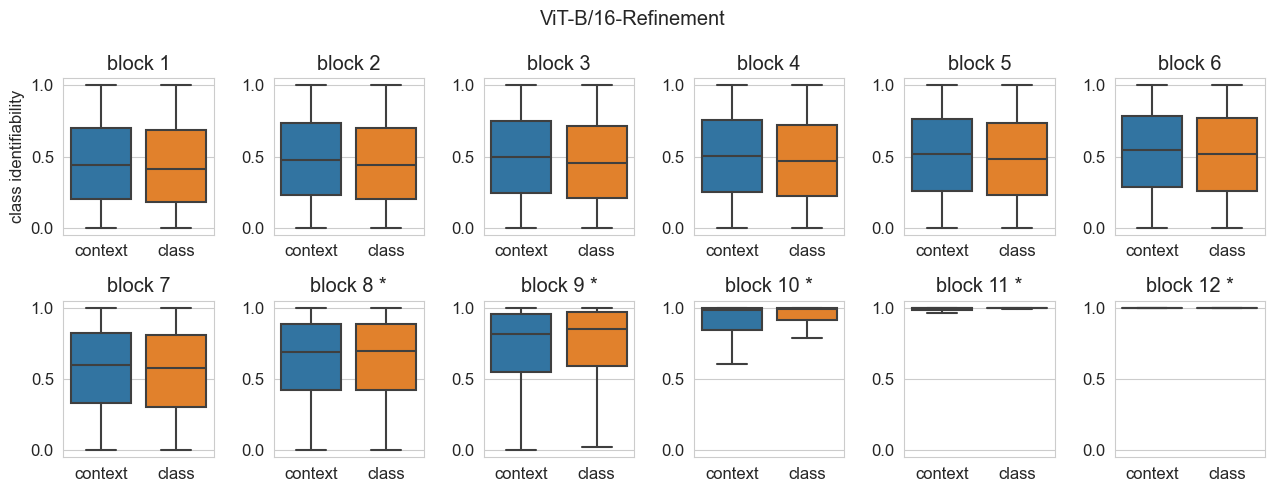

In [60]:
plot_context_diff('deit_ensemble_16')

#### ViT-B/16 - GAP

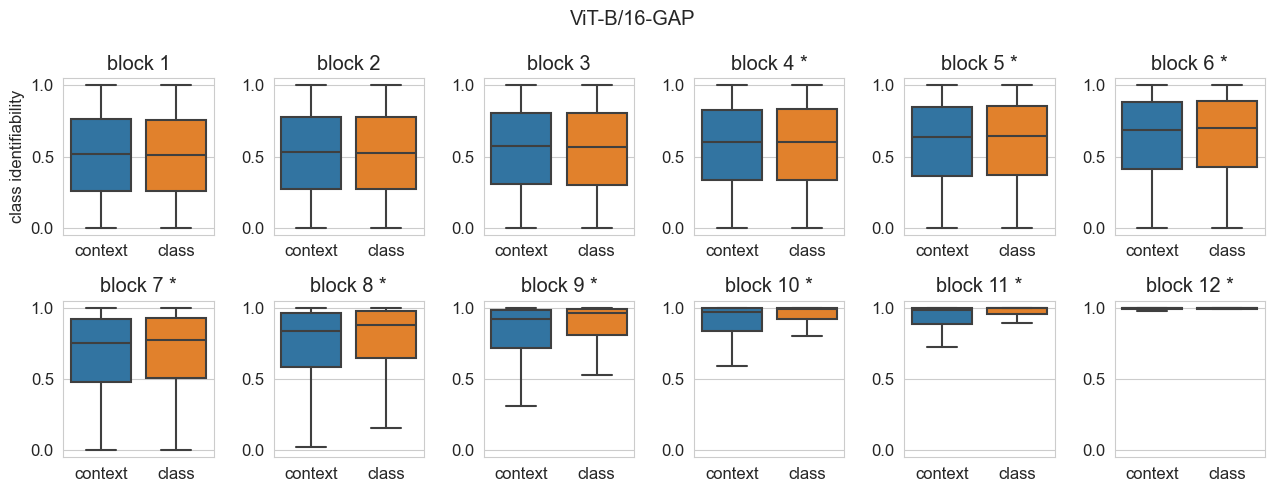

In [61]:
plot_context_diff('vit_gap_16')

### Context perturbation studies

We removed either context-labeled or class-labeled tokens from the input (after the addition of position embeddings), and measured the class-identifiability rates of the remaining image tokens in the last block.

In [62]:
def print_context_perturb(model_name, mask_type):
    """
    Print class identifiability of context perturbation studies.
    """
    # Get identifiability of perturbed model
    f = RES_PATH / 'perturbation' / model_name / f'no_{mask_type}_tokens_dec.pt'
    context_dec = torch.load(f, map_location='cpu')['hs_11']
    context_dec_acc = []
    for i in context_dec:
        i = 1 - (i / 1000)
        context_dec_acc.append(torch.sum(i == 1) / i.shape[0])
    context_dec_acc = torch.mean(torch.stack(context_dec_acc)) * 100
    print(f'Class identifiability with no {mask_type} tokens: {context_dec_acc}')

    # Get identifiability of unperturbed model
    im = Vis(PROJ_PATH, DATASET_PATH, model_name, device='cpu')
    stim_info = im.stim_info
    concepts = stim_info['imagenet_id'].unique().tolist()
    sgts = []
    for c in concepts:
        for i in range(5):
            gt = im.get_segmentation(c, i).flatten()
            sgts.append(gt)
    sgts = np.hstack(sgts)
            
    dec = get_class_embed(
        RES_PATH, DATASET_PATH, model_name, 'hs_11', decoding_type='pos', normalize=True
    )[:, 1:]
    dec = dec.flatten()
    if mask_type == 'context':
        dec = dec[(sgts == 1).nonzero()]
    elif mask_type == 'class_label':
        dec = dec[(sgts == 0).nonzero()]
    dec_acc = torch.sum(dec == 1) / dec.shape[0] * 100
    print(f'Class identifiability in unperturbed model: {dec_acc}')
    
    return

#### ViT-B/32 and no context-labeled image tokens

In [63]:
print_context_perturb('vit_b_32', mask_type='context')

Class identifiability with no context tokens: 44.70477294921875
Class identifiability in unperturbed model: 71.91523742675781


#### ViT-B/32 and no class-labeled image tokens

In [64]:
print_context_perturb('vit_b_32', mask_type='class_label')

Class identifiability with no class_label tokens: 38.683494567871094
Class identifiability in unperturbed model: 56.24493408203125
